# CIFAR-10 Dataset:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

CIFAR-10 dataset contains images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="images/1.jpg" style="width:50%">

In [30]:
import tensorflow as tf
import keras
import os
import math
import pickle
import cPickle
import cv2
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler

print(tf.__version__)
print(keras.__version__)

1.11.0
2.2.4


# Load dataset

### 1. Download the dataset from [here](http://www.cs.toronto.edu/~kriz/cifar.html) and read in python 

X Shape: (60000, 32, 32, 3)
Y Shape: (60000, 1)

 Sample Image:
: AxesImage(54,36;334.8x217.44)


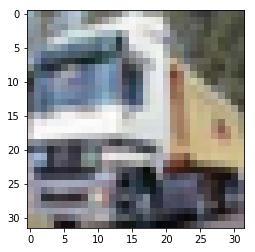

In [6]:
data = []
labels = []

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

for f in os.listdir("cifar-10-batches-py/"):
    if "_batch" in f:
        data.extend(unpickle("cifar-10-batches-py/" + str(f))['data'])
        labels.extend(unpickle("cifar-10-batches-py/" + str(f))['labels'])
        
X_data = np.stack(data, axis=0)  ## This read flattern image (60000, 3072)
X_data = np.reshape(X_data, (60000, 32, 32, 3), order='F') # Convert into RGB (60000, 32, 32, 3)
X_data = np.transpose(X_data,(0,2,1,3)) # Images are rotated, so take a transpose

Y_data = np.stack(labels, axis = 0)
Y_data = np.reshape(Y_data, (60000,1))

print "X Shape:", X_data.shape
print "Y Shape:", Y_data.shape

print "\n Sample Image:\n:", plt.imshow(X_data[1])

### 2. Load the dataset using keras .load_data() function

In [7]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

('Train samples:', (50000, 32, 32, 3), (50000, 1))
('Test samples:', (10000, 32, 32, 3), (10000, 1))


In [9]:
nclasses = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


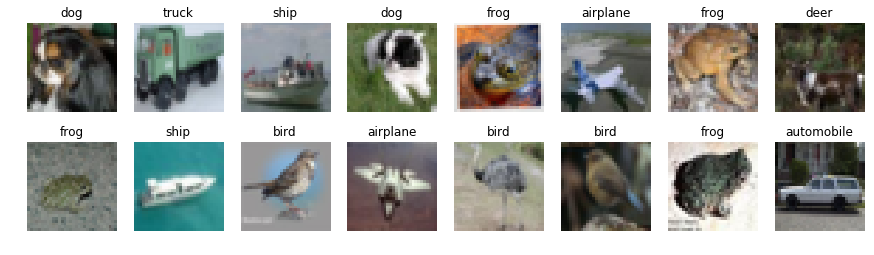

In [10]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Prepare data

We need to normalize inputs like this: 
$$x_{norm} = \frac{x}{255} - 0.5$$

In [11]:
# normalize inputs
x_train_norm = (x_train.astype(float)/255) - 0.5
x_test_norm = (x_test.astype(float)/255) - 0.5

# One-Hot encoding for output
y_train_one_hot = np.eye(nclasses)[y_train[:,0]]
y_test_one_hot = np.eye(nclasses)[y_test[:,0]]

print "X shape:", x_train_norm.shape 
print "Y shape:", y_train_one_hot.shape

X shape: (50000, 32, 32, 3)
Y shape: (50000, 10)


# Define CNN architecture

In [12]:
# import necessary building blocks

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

Model:

Cov2D layer with 16, 3 X 3 filters ---> LeakyReLu ---> Conv2D layer with 32, 3 X 3 filters ---> LeakyReLu ---> MaxPooling2D 2 X 2 ---> Dropout ---> Conv2D layer with 128, 3 X 3 ---> LeakyReLu ---> Conv2D layer with 128, 3 X 3 ---> LeakyReLu ---> MaxPooling2D 2 X 2 ---> Dropout ---> Flatten (Dense layer) 1024 ---> LeakyReLu ---> Dropout ---> Dense layer 10 ---> SoftMax ---> Output 



Input: __(None, 32, 32, 3)__ 
Output: __(None, 10)__  (probabilities for all classes)
. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```

Use __LeakyReLU__ activation with recommended parameter __0.1__ for all layers that need it (after convolutional and dense layers):
```python
model.add(LeakyReLU(0.1))
```

Add a dense layer with __256__ neurons and a second dense layer with __10__ neurons for classes. Remember to use __Flatten__ layer before first dense layer to reshape input volume into a flat vector!

Add __Dropout__ after every pooling layer (__0.25__) and between dense layers (__0.5__).

In [15]:
def cnn_model():

    model = Sequential()
    
    #Conv 1
    model.add(Conv2D(16, kernel_size=(3, 3),input_shape=(32, 32, 3), padding="same", strides = (1, 1), name = "conv1"))
    model.add(LeakyReLU(0.1))
    
    #Conv 2
    model.add(Conv2D(32, kernel_size=(3, 3), strides = (1, 1), padding="same", name = "conv2"))
    model.add(LeakyReLU(0.1))
    
    #MaxPooling 1
    model.add(MaxPooling2D(pool_size=(2, 2), name = "max_pool_1"))
    model.add(Dropout(0.25, noise_shape=None, seed=0))

    #Conv 3
    model.add(Conv2D(32, kernel_size=(3, 3), strides = (1, 1), padding="same", name = "conv3"))
    model.add(LeakyReLU(0.1))
    
    #Conv 4
    model.add(Conv2D(64, (3, 3), strides = (1, 1), padding="same", name = 'conv4'))  
    model.add(LeakyReLU(0.1))
    
    #MaxPooling 2
    model.add(MaxPooling2D(pool_size=(2, 2), name = "max_pool_2"))
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    
    #Flatten
    model.add(Flatten())    
    
    #Fully Connected
    model.add(Dense(256, name='fc1'))
    model.add(Dropout(0.5, noise_shape=None, seed=0))
    
    #Fully Connected
    model.add(Dense(nclasses))  #dense layer with number of classes   
    model.add(Activation("softmax"))  #apply softmac to get probabilities

    return model

K.clear_session()
model = cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 32)        9248      
__________

In [22]:
## Plot Model Accuracy

def plot_fig(i, history, epochs):
    fig = plt.figure()
    plt.plot(range(1,epochs+1),history.history['val_acc'],label='validation')
    plt.plot(range(1,epochs+1),history.history['acc'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.xlim([1,epochs])
    #plt.ylim([0,1])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()
    plt.close(fig)

# Train model

The Goal here is apply various learning rate decay methods.

### 1. No learning rate decay

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 95s 2ms/step - loss: 1.5602 - acc: 0.4391 - val_loss: 1.2318 - val_acc: 0.5680
Epoch 2/3
50000/50000 [==============================] - 95s 2ms/step - loss: 1.1773 - acc: 0.5831 - val_loss: 1.0213 - val_acc: 0.6436
Epoch 3/3
50000/50000 [==============================] - 95s 2ms/step - loss: 1.0225 - acc: 0.6424 - val_loss: 0.9229 - val_acc: 0.6807


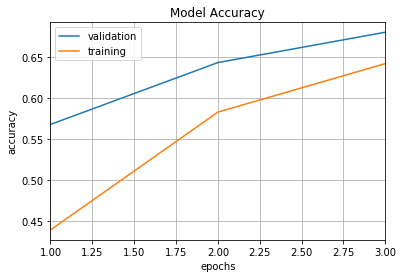

CPU times: user 25min 48s, sys: 12min 31s, total: 38min 19s
Wall time: 4min 46s


In [24]:
%%time

model_1 = cnn_model()

# prepare model for fitting (loss, optimizer, etc)
model_1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0005, decay=0.0),metrics=['accuracy'])

# fit model
model_a = model_1.fit(x_train_norm, y_train_one_hot, 
                      batch_size=128, 
                      shuffle=True,
                      epochs=3,
                      validation_data=(x_test_norm, y_test_one_hot),
                      callbacks=[EarlyStopping(min_delta=0.001, patience=3)])

# plot model accuracy
plot_fig(1, model_a, 3)

### 2. Contant learning rate decay

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 96s 2ms/step - loss: 1.5698 - acc: 0.4396 - val_loss: 1.2651 - val_acc: 0.5516
Epoch 2/3
50000/50000 [==============================] - 99s 2ms/step - loss: 1.2017 - acc: 0.5741 - val_loss: 1.0641 - val_acc: 0.6240
Epoch 3/3
50000/50000 [==============================] - 98s 2ms/step - loss: 1.0611 - acc: 0.6267 - val_loss: 0.9575 - val_acc: 0.6632


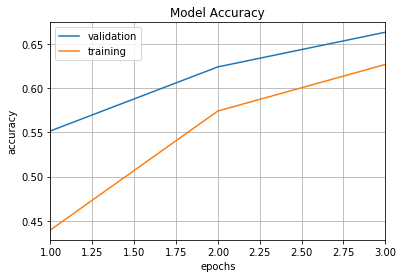

CPU times: user 26min 14s, sys: 12min 40s, total: 38min 54s
Wall time: 4min 53s


In [25]:
%%time

model_2 = cnn_model()

learning_rate = 0.0005
decay_rate = learning_rate / epochs

# prepare model for fitting (loss, optimizer, etc)
model_2.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=learning_rate, decay= decay_rate),
                metrics=['accuracy'])

# fit model
model_b = model_2.fit(x_train_norm, y_train_one_hot, 
                      batch_size=128, 
                      shuffle=True,
                      epochs=3,
                      validation_data=(x_test_norm, y_test_one_hot),
                      callbacks=[EarlyStopping(min_delta=0.001, patience=3)])

# plot model accuracy
plot_fig(2, model_b, 3)

### 3. Learning rate (step) decay at every epoch 

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 97s 2ms/step - loss: 1.5764 - acc: 0.4340 - val_loss: 1.2592 - val_acc: 0.5500
('Learning rate:', 0.00025)
Epoch 2/3
50000/50000 [==============================] - 97s 2ms/step - loss: 1.2254 - acc: 0.5626 - val_loss: 1.1111 - val_acc: 0.6059
('Learning rate:', 0.000125)
Epoch 3/3
50000/50000 [==============================] - 98s 2ms/step - loss: 1.1161 - acc: 0.6063 - val_loss: 1.0468 - val_acc: 0.6277
('Learning rate:', 6.25e-05)


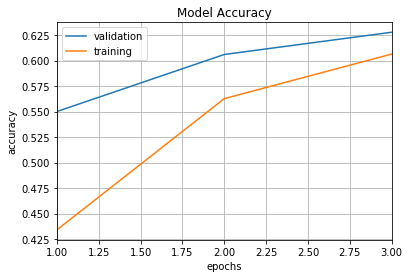

CPU times: user 26min 2s, sys: 12min 46s, total: 38min 49s
Wall time: 4min 52s


In [34]:
%%time

model_3 = cnn_model()

epochs = 3
learning_rate = 0.0005
decay_rate = learning_rate / epochs

# prepare model for fitting (loss, optimizer, etc)
model_3.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr = learning_rate),
                metrics=['accuracy'])

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('Learning rate:', step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 0.0005
    drop = 0.5
    epochs_drop = 1.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(min_delta=0.001, patience=3)
callbacks_list = [loss_history, lrate, early_stopping]

# fit model
model_c = model_3.fit(x_train_norm, y_train_one_hot, 
                      batch_size=128, 
                      shuffle=True,
                      epochs=3,
                      validation_data=(x_test_norm, y_test_one_hot),
                      callbacks=callbacks_list)

# plot model accuracy
plot_fig(3, model_c, 3)

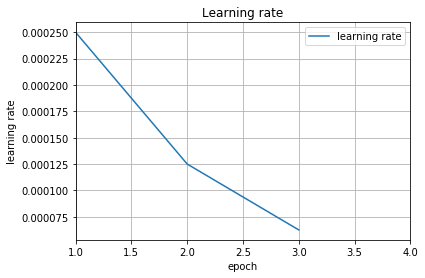

In [40]:
# plot learning rate

epochs = 3

fig = plt.figure()
plt.plot(range(1,epochs+1),loss_history.lr,label='learning rate')
plt.xlabel("epoch")
plt.xlim([1,epochs+1])
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()

### 4. Learning rate (exponential) decay at every epoch 

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 95s 2ms/step - loss: 1.5589 - acc: 0.4410 - val_loss: 1.2354 - val_acc: 0.5706
('Learning rate:', 0.00025)
Epoch 2/3
50000/50000 [==============================] - 94s 2ms/step - loss: 1.1946 - acc: 0.5777 - val_loss: 1.0522 - val_acc: 0.6324
('Learning rate:', 0.000125)
Epoch 3/3
50000/50000 [==============================] - 98s 2ms/step - loss: 1.0505 - acc: 0.6282 - val_loss: 0.9729 - val_acc: 0.6610
('Learning rate:', 6.25e-05)


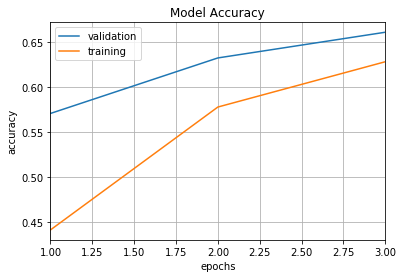

CPU times: user 26min 11s, sys: 12min 22s, total: 38min 33s
Wall time: 4min 47s


In [41]:
%%time

model_4 = cnn_model()

epochs = 3
learning_rate = 0.0005
decay_rate = learning_rate / epochs

# prepare model for fitting (loss, optimizer, etc)
model_4.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr = learning_rate),
                metrics=['accuracy'])

# define step decay function
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('Learning rate:', step_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 0.0005
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate


# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(exp_decay)
early_stopping = EarlyStopping(min_delta=0.001, patience=3)
callbacks_list = [loss_history, lrate, early_stopping]

# fit model
model_d = model_4.fit(x_train_norm, y_train_one_hot, 
                      batch_size=128, 
                      shuffle=True,
                      epochs=3,
                      validation_data=(x_test_norm, y_test_one_hot),
                      callbacks=callbacks_list)

# plot model accuracy
plot_fig(4, model_d, 3)